In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact
import glob, re
from pprint import pprint
from scipy.constants import elementary_charge as qe, electron_mass as me

%matplotlib inline

In [2]:
def load_dsp(df, line_nr=[91, 92, 93, 120]):
    """
    Loads a .dsp file from Maxwell and extracts elements, nodes and the solution at the nodes.
    For this code to work, the data must have been saved as a dsp file, with only a single plot in the Fields tab.
    :param df: File path of the data file
    :return: elements, node, element solution, bounding box
    """
    with open(df, 'r') as myfile:
        data = myfile.readlines()

    # The important data is stored on line numbers 91-93.
    # Line 91: Elements: Each element is composed of 6 nodes. Each sequence of 2,3,3,0,6 is followed by 6 points, which will
    # make up a single element. First 2 entries are diagnostic info.
    # Line 92: Node coordinates. One node coordinate has 3 entries: x, y, z
    # Line 93: Solution on each node. First 3 entries are diagnostic info.

    elements = np.array(re.findall(r"\((.*?)\)", data[line_nr[0]-1])[0].split(', '), dtype=int)
    nodes = np.array(re.findall(r"\((.*?)\)", data[line_nr[1]-1])[0].split(', '), dtype=float)
    elem_solution = np.array(re.findall(r"\((.*?)\)", data[line_nr[2]-1])[0].split(', '), dtype=float)

    nodes = nodes.reshape((int(nodes.shape[0]/3), 3))

#     line_nr = 90
    bounding_box = np.array(re.findall(r"\((.*?)\)", data[line_nr[3]-1])[0].split(', '), dtype=float)

    return elements, nodes, elem_solution[3:], bounding_box

## Potential slices

In [9]:
# lines = [[121, 122, 123, 120], 
#          [132, 133, 134, 131], 
#          [143, 144, 145, 142]]

Nheights = 11

names = ["Resonator", "Trap", "Trapguard", "Resonatorguard"]
lines = [[391 + 11*k, 392 + 11*k, 393 + 11*k, 390 + 11*k] for k in range(Nheights)]

xeval = np.linspace(-4., 4., 101)
yeval = anneal.construct_symmetric_y(-5, 251)

output = list()
for mm, name in enumerate(names):
    datapath = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files Smarter Saved"
    df = os.path.join(datapath, "%s.dsp" % name)

    for nn, linez in tqdm(enumerate(lines)):
        elements, nodes, solution, bbox = load_dsp(df, line_nr=linez)
#         print("h = ",bbox[4], "um")
        xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, solution)
        xcenter = np.mean(bbox[0:2])
        ycenter = np.mean(bbox[2:4])
        xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                             plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False, plot_data=0)

        # Mirror around the y-axis
        ysize, xsize = np.shape(Uinterp)
        Uinterp_symmetric = np.zeros((2 * ysize, xsize))
        Uinterp_symmetric[:ysize, :] = Uinterp
        Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

        y_symmetric = np.zeros((2 * ysize, xsize))
        y_symmetric[:ysize, :] = yinterp
        y_symmetric[ysize:, :] = -yinterp[::-1, :]

        x_symmetric = np.zeros((2 * ysize, xsize))
        x_symmetric[:ysize, :] = xinterp
        x_symmetric[ysize:, :] = xinterp

        if nn == 0:
            output.append({'name' : name, 
                   'V' : np.zeros((2 * ysize, xsize, Nheights), dtype=np.float64),
                   'x' : np.zeros((2 * ysize, xsize, Nheights), dtype=np.float64), 
                   'y' : np.zeros((2 * ysize, xsize, Nheights), dtype=np.float64), 
                   'helium_height' : np.zeros(Nheights)})

        output[mm]['V'][:, :, nn] = Uinterp_symmetric
        output[mm]['x'][:, :, nn] = x_symmetric
        output[mm]['y'][:, :, nn] = y_symmetric
        output[mm]['helium_height'][nn] = bbox[4]
    
    # Sort according to ascending helium height
    proper_order = np.argsort(output[mm]['helium_height'])
    output[mm]['helium_height'] = output[mm]['helium_height'][proper_order]
    output[mm]['x'] = output[mm]['x'][:, :, proper_order]
    output[mm]['y'] = output[mm]['y'][:, :, proper_order]
    output[mm]['V'] = output[mm]['V'][:, :, proper_order]

#         plt.figure()
#         common.configure_axes(13)
#         plt.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric)
#         plt.title(r"$h$ = %s $\mu$m" % bbox[4])

11it [00:25,  2.07s/it]
11it [00:19,  1.60s/it]
11it [01:03,  5.01s/it]
11it [01:02,  5.04s/it]


## Curvatures

100%|██████████| 11/11 [01:09<00:00,  6.20s/it]


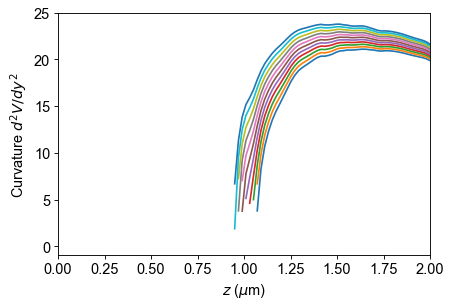

In [28]:
names = ["Resonator", "Trap", "Resonatorguard", "Trapguard"]

plt.figure()

for Vtraps in tqdm(np.linspace(0.35, 0.55, 11)):
    volts = [1.00, Vtraps, -0.60, 0.00]
    
    for k, name in enumerate(names):
        datapath = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\Helium Fluctuation Files Smarter Saved"
        df = os.path.join(datapath, "%s_2D_Curvature_XZ.dsp" % name)

        xeval = np.linspace(-4, 4, 100)
        zeval = np.linspace(0, 2, 100)

        elements, nodes, solution, bbox = load_dsp(df, line_nr=[92, 93, 94, 91])
        xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, solution)
        xcenter = np.mean(bbox[0:2])
        ycenter = np.mean(bbox[2:4])
        xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=zeval, clim=None, 
                                                             plot_axes='xz', cmap=plt.cm.viridis, plot_mesh=0, plot_data=0)

        if k == 0: 
            curvature_total = Uinterp * volts[k]
        else:
            curvature_total += Uinterp * volts[k]

    xoi = -0.5
    xoi_idx = common.find_nearest(xoi, xinterp)

    plt.plot(yinterp[:, xoi_idx], np.sqrt(-1.602E-19 * curvature_total[:, xoi_idx] / 9.11E-31) / (2 * np.pi * 1E9), 
             label=Vtraps)
    # plt.ylim(-1E11, 0)

plt.xlim(0, 2)
plt.xlabel("$z$ ($\mu$m)")
plt.ylabel("Curvature $d^2 V/dy^2$ ")
        
# plt.figure(figsize=(8.,4.))
# common.configure_axes(13)
# plt.pcolormesh(xinterp, yinterp, curvature_total)
# plt.xlabel("$x$ ($\mu$m)")
# plt.ylabel("$z$ ($\mu$m)")
# plt.title("Combined $d^2 V/d y^2$")

# plt.colorbar()
# plt.clim(0E11, 7E11)

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


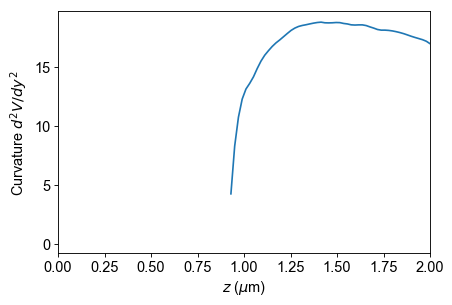

In [25]:
xoi = -0.5
xoi_idx = common.find_nearest(xoi, xinterp)

plt.figure()
plt.plot(yinterp[:, xoi_idx], np.sqrt(-1.602E-19 * curvature_total[:, xoi_idx] / 9.11E-31) / (2 * np.pi * 1E9))
# plt.ylim(-1E11, 0)
plt.xlim(0, 2)
plt.xlabel("$z$ ($\mu$m)")
plt.ylabel("Curvature $d^2 V/dy^2$ ")

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02020202,  0.02020202,  0.02020202, ...,  0.02020202,
         0.02020202,  0.02020202],
       [ 0.04040404,  0.04040404,  0.04040404, ...,  0.04040404,
         0.04040404,  0.04040404],
       ..., 
       [ 1.95959596,  1.95959596,  1.95959596, ...,  1.95959596,
         1.95959596,  1.95959596],
       [ 1.97979798,  1.97979798,  1.97979798, ...,  1.97979798,
         1.97979798,  1.97979798],
       [ 2.        ,  2.        ,  2.        , ...,  2.        ,
         2.        ,  2.        ]])